# Optimal Portfolio
This notebook construct 3 different optimal portfolios. The maximum sharpe-ratio portfolio (*simple risk adjusted return*), the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*) and the minimum variance portfolio.

\begin{align}
    \text{Sharpe Ratio}&=\frac{R_{p}-R_{f}}{\sigma_{p}}\\
    \text{Calmar Ratio}&=\frac{R_{p}-R_{f}}{\text{Maximum Drawdown}}
\end{align}
where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate, $\sigma_{p}$ denotes the standard deviation ($\approx$*risk*) of the portfolio and maximum drawdown is measured as the pct.-change from trough to peak, i.e. peak-value minus trough-value divided by peak-value.




In [1]:
############## Loading relevant packages ##############
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# local module
import pftools
import VaR_and_ES as vares
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [2]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE']

# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','C:/Users/olufk/OneDrive/Documents/GitHub/PortfolioDesign/PortfolioDesign/OptimalPF/Data_Investing_com/')

Will eventually output description of each ticker in df


In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['fortum.he', 'danske.co', 'saf.pa', 'wm']

# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
# df, rdf, cdf = pftools.df_generator(tickers,'yahoo')

## Describing each tickers
Now that data is loaded, it's time to get an idea of the characteristics of the tickers

C:\Users\olufk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\olufk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\olufk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\olufk\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


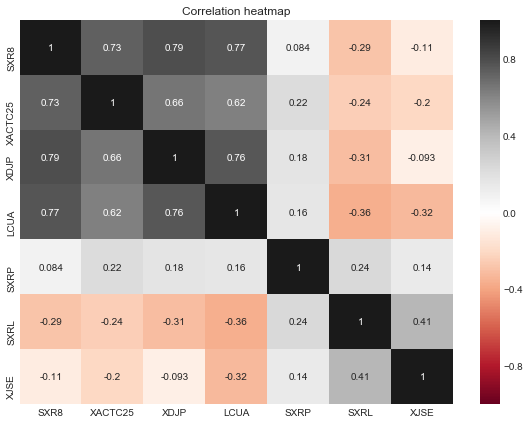

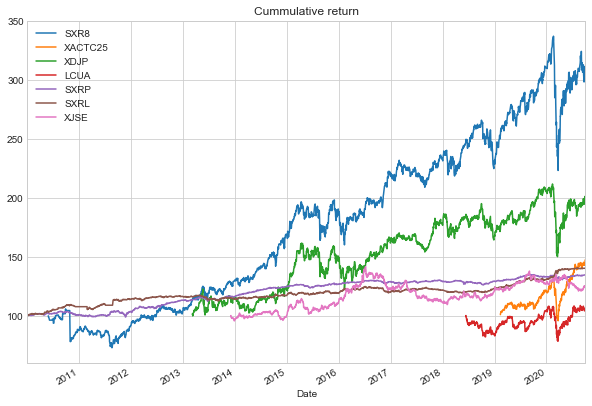

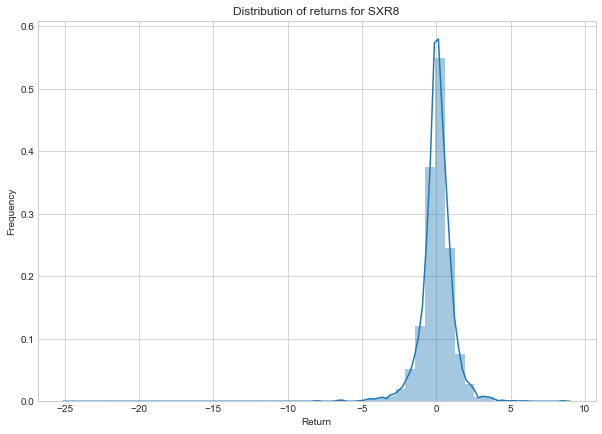

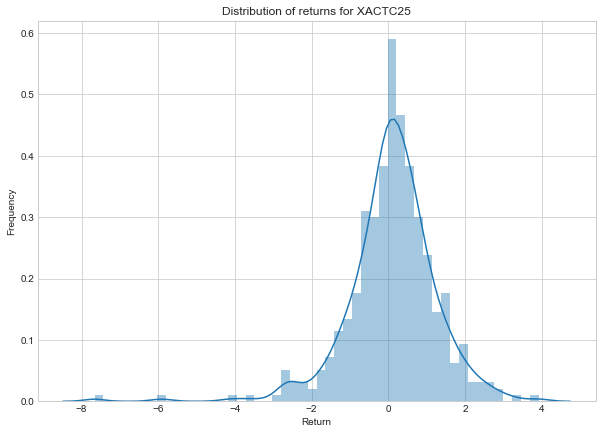

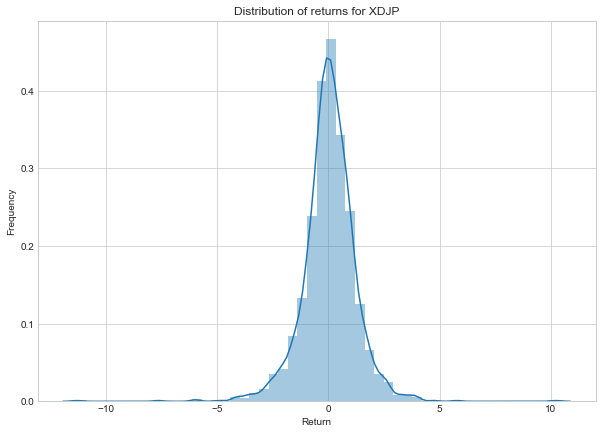

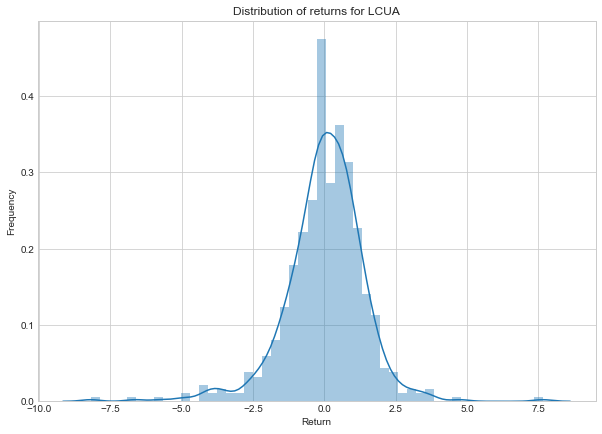

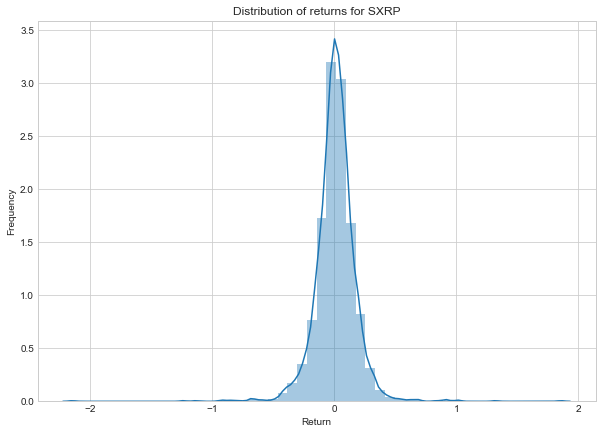

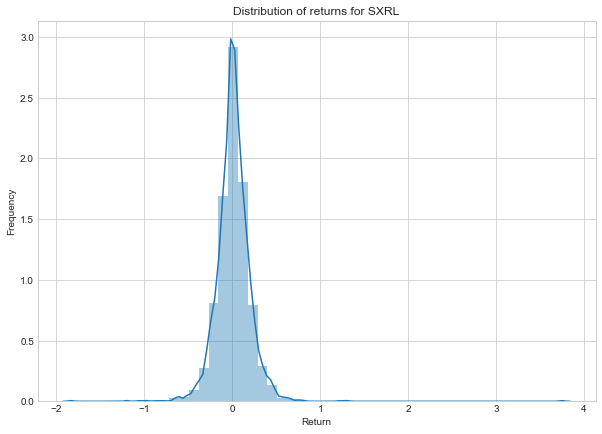

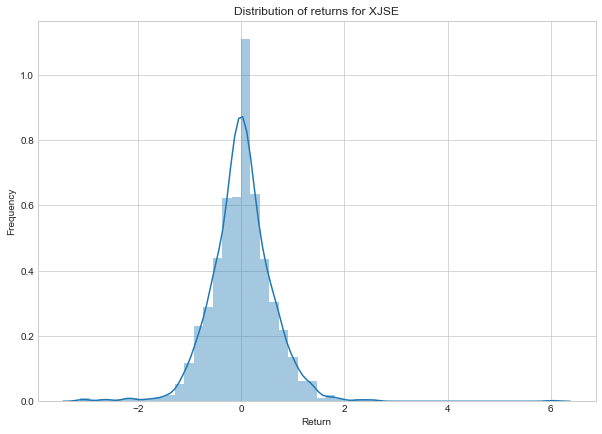

,Ticker,annualized_return,volatility,sharpe_ratio,calmar_ratio
0,SXR8,7.88,18.17,0.43,0.32
1,XACTC25,17.67,18.46,0.96,2.31
2,XDJP,6.50,19.11,0.34,0.57
3,LCUA,2.03,22.31,0.09,0.25
4,SXRP,1.93,2.71,0.71,0.90
5,SXRL,2.20,3.15,0.70,1.20
6,XJSE,2.19,9.59,0.23,0.70


In [4]:
pftools.desc_ticks(df,rdf,cdf)

In [11]:
omega_hat, alpha_hat, ll = vares.ARCH11_est('LCUA',df)

Estimating LCUA as a ARCH(1,1)-model resulted in:
Omega^hat                       --> 1.6445 with std. errors (0.0799) and t-val 20.5738
alpha^hat                       --> 0.1701 with std. errors (0.0346) and t-val 4.9104
Maximized log-likelihood        --> -958.364


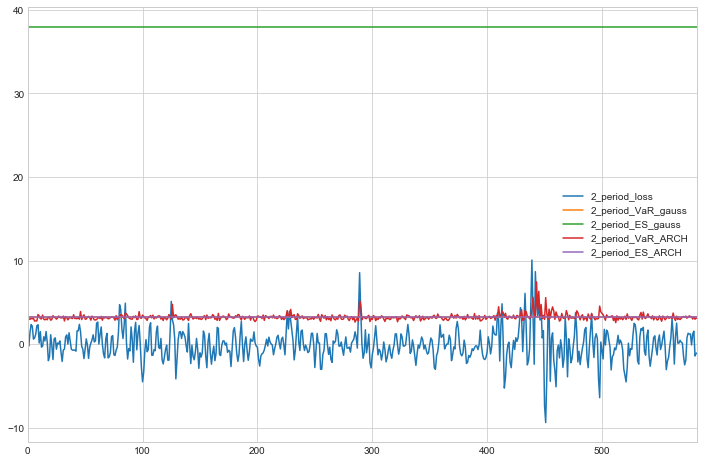

In [84]:
ES_ARCH1, var_df = vares.VaR(omega_hat,alpha_hat,df,'LCUA',0.05,2,500)
var_df.plot(figsize = (12,8));
# ES_ARCH1

In [98]:
# ES_gauss = np.empty(10000)
# from scipy.stats import norm
# ES_gauss.fill(5)
var_df
# ES_gauss
alpha = 0.05
sigma_hat = 0.00794647
print(alpha**(-1)*sigma_hat*norm.ppf(norm.cdf(1-0.05)))
print(alpha**(-1)*sigma_hat*norm.cdf(norm.ppf(0.05)))
print(alpha**(-1)*sigma_hat*norm.pdf(norm.cdf(0.05)))
# should be equal to 0.01639

0.15098293000000002
0.007946469999999995
0.05538746830817003


In [5]:
def data_prep(df,col):
    x = np.array(df[col])
    x = x[~np.isnan(x)]
    logR = np.diff(np.log(x))*100
    return logR

In [6]:
def ARCH11_ll(theta,logR):
    # i. unpacking parameter values
    omega = theta[0]
    alpha = theta[1]
    
    # ii. retrieving max periods
    T = len(logR)
    
    # iii. initializing sigma2 series
    sigma2 = np.empty(T)
    sigma2[0] = np.var(logR) # starting at simple variance of returns
    sigma2[0] = 1 # starting at 1
    
    # iv. estimating sigma2 in ARCH(1,1) process
    for t in range(1,T):
        sigma2[t] = omega+alpha*logR[t-1]**2
    
    # v. calculating the log-likelihood to be optimized (negative)
    LogL = -np.sum(-np.log(sigma2)-logR**2/sigma2)
    
    return LogL

In [7]:
x = data_prep(df,'LCUA')
x
ARCH11_ll(([0.25,2]),x)

7053.85970625796

In [8]:
def ARCH11_est(ticker, df, printres = True):
    # i. retrieving data
    logR = data_prep(df,ticker)
    
    # ii. initial guess
    theta0 = ([0.25,2])
    
    # iii. optimizing
    sol = optimize.minimize(lambda x: ARCH11_ll(x,logR), theta0, bounds = ((1e-8,None),(0,None)))
    
    # iv. unpacking estimates
    omega_hat = sol.x[0]
    alpha_hat = sol.x[1]
    logl = -sol.fun
    
    # v. computing standard errors
    # negative inverse hessian matrix (we have minimized negative log-likelihood)
    v_hessian = sol.hess_inv.todense()
    se_hessian = np.sqrt(np.diagonal(v_hessian))
    
    
    # vi. printing result
    if printres == True:
        print(f'Estimating {ticker} as a ARCH(1,1)-model resulted in:')
        print(f'Omega^hat                       --> {omega_hat:.4f} with std. errors ({se_hessian[0]:.4f}) and t-val {omega_hat/se_hessian[0]:.4f}')
        print(f'alpha^hat                       --> {alpha_hat:.4f} with std. errors ({se_hessian[1]:.4f}) and t-val {alpha_hat/se_hessian[1]:.4f}')
        print(f'Maximized log-likelihood        --> {logl:.3f}')
    
    
    return omega_hat, alpha_hat, logl

In [9]:
from scipy import optimize
omega_hat,alpha_hat,logl = ARCH11_est('SXR8', df)

Estimating SXR8 as a ARCH(1,1)-model resulted in:
Omega^hat                       --> 1.2175 with std. errors (0.0263) and t-val 46.3478
alpha^hat                       --> 0.1339 with std. errors (0.0161) and t-val 8.3098
Maximized log-likelihood        --> -3377.606


In [10]:
h = 2
T = len(x)
loss = np.zeros(T-h+1)
j = 0
for i in reversed(range(h)):
    loss -= x[i:T-j]
    j += 1
loss

array([ 0.5185837 ,  1.09444664,  0.58663938, ..., -3.07759833,
       -1.23736112, -0.07608508])

In [14]:
# simulating return for a ARCH(1,1)-process with a h-period loss
from scipy.stats import norm
omega = omega_hat
a = alpha_hat
M = 1000
T = len(x)
h = 2
alpha = .05
temp1 = np.zeros(M)
temp2 = -np.sqrt(np.var(x))*np.sqrt(h)*norm.ppf(alpha)
temp2


# c. initializing VaR variable
VaR_ARCH11 = np.zeros(T-h+1)
ES_ARCH1[ii] = np.zeos(T-h+1)
VaR_gauss = np.zeros(T-h+1)

temp=np.zeros(M)


# ii. calculating VaR for ARCH(1,1) process
for ii in range(T-h+1): # check h is correct here as well!!!
    for jj in range(M):
        z = np.random.normal(loc = 0, scale = 1, size = h) # drawing innovations
        r1=np.sqrt(omega+a*x[ii]**2)*z[0] #//compute return at time i+1
        r2=np.sqrt(omega+a*r1**2)*z[1] #//compute return at time i+2
        temp[jj]=-(r1+r2)#//compute two-period loss
        
        # i. simulating h period loss' in period t for 
#         for ij in range(h):

#             if ij == 0:
#                 temp[jj] -= np.sqrt(omega+a*x[ii]**2)*z[ij]
#             temp[jj] -= np.sqrt(omega+a*temp[jj]**2)*z[ij]
    
    VaR_ARCH11[ii] = np.quantile(temp,1-alpha)
    ES_ARCH1[ii] =  alpha**(-1)*np.quantile(temp,1-alpha)
    VaR_gauss[ii] = temp2

print(len(VaR_gauss))
VaR_ARCH11

2623


array([2.54643194, 2.67263737, 2.65448165, ..., 2.70346296, 2.6346327 ,
       2.69360866])

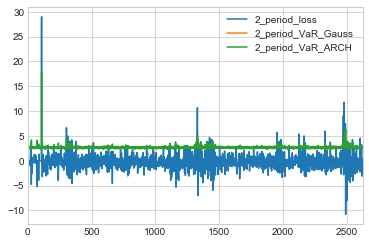

In [15]:
df=pd.DataFrame(loss, columns=["2_period_loss"])
df["2_period_VaR_Gauss"]=VaR_gauss
df["2_period_VaR_ARCH"]=VaR_ARCH11
df.plot();